# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from tqdm import tqdm
import json

In [2]:
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow import keras
from tensorflow.keras import layers

# Load Data

In [ ]:
# import pandas as pd

# df = pd.read_csv('../../dataset/weighted_score_above_08.csv')

# df.head()

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_97330/410107815.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../dataset/weighted_score_above_08.csv')


,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,1696305457,...,1,99,2,0.889438,0,1,0,0,1,NaN
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,1696096555,...,1,122,8,0.914834,0,1,0,0,1,NaN
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,1697630734,...,1,599,20,0.968375,3,1,0,0,1,NaN
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,1698261011,...,1,59,12,0.826206,0,0,0,0,1,NaN
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,1697810991,...,1,128,24,0.853612,0,1,0,0,1,NaN


In [5]:
with open('../combined_df.json', 'r') as f:
    sample_data = [json.loads(line) for line in f]

In [3]:
# Extract valid appids from the sample file
# valid_appids = {entry['appid'] for entry in sample_data}

# Filter df based on appids in the sample
# df = df[df['appid'].isin(valid_appids)]

# Continue processing
# df_games = df[['appid', 'game']]
# df_games = df_games.drop_duplicates(subset='appid')

# appid2game = df_games.set_index('appid')['game'].to_dict()
# game2appid = df_games.set_index('game')['appid'].to_dict()

# del df_games

# df = df[['appid', 'author_steamid', 'voted_up']]
# df.rename(columns={'appid': 'item_id', 'author_steamid': 'user_id', 'voted_up': 'rating'}, inplace=True)

In [6]:
item_id_to_genres = {entry['appid']: entry['genre'] for entry in sample_data}

In [ ]:
# df.reset_index(drop=True, inplace=True)

In [7]:
# N_DISPLAY = 30
# has_no_genre_count = 0
# for i, item_id in enumerate(df['item_id'].unique()):
#     genres = item_id_to_genres.get(item_id, [])
#     if not genres:
#         has_no_genre_count += 1
#         continue
# print(f"Number of games without genres: {has_no_genre_count}")

In [9]:
# nan_count = df['rating'].isna().sum()
# print(f"Number of NaN values in 'rating': {nan_count}")

In [10]:
sample_data[0]

{'appid': 550, 'game': 'Left 4 Dead 2', 'genre': ['Action']}

In [ ]:
# Create a DataFrame from sample_data
movies_data_clean = pd.DataFrame(sample_data)

# Rename columns for clarity
movies_data_clean.rename(columns={'game': 'title'}, inplace=True)

# Convert the 'genre' list into a pipe-separated string
movies_data_clean['genre'] = movies_data_clean['genre'].apply(lambda x: '|'.join(x) if isinstance(x, list) else '')

# Select only the required columns
movies_data_clean = movies_data_clean[['appid', 'title', 'genre']]
movies_data_clean.rename(columns={'appid': 'movieId'}, inplace=True)
movies_data_clean.rename(columns={'genre': 'genres'}, inplace=True)

movies_data_clean.head()

,movieId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


### Create Item Train Feature Vectors

In [ ]:
movie_features_data = movies_data_clean.copy()

In [19]:
movie_features_data.head()

,movieId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


In [20]:
genre_dummies = movie_features_data['genres'].str.get_dummies(sep='|')

In [21]:
item_genre_dummies = genre_dummies.add_prefix('item_')

In [244]:
item_features = pd.concat([
    # movie_features_data[['movieId']],
    item_genre_dummies
], axis=1)

In [245]:
item_features.head()

,item_360 Video,item_Accounting,item_Action,item_Additional High-Quality Audio,item_Adventure,item_Akció,item_Aksiyon,item_Animation & Modeling,item_Audio Production,item_Aventura,...,item_冒险,item_动作,item_大型多人在线,item_抢先体验,item_模拟,item_無料プレイ,item_独立,item_竞速,item_策略,item_角色扮演
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
item_features.shape

(27315, 134)

#### Train an autoencoder

In [247]:
item_continuous = []
item_genres = [c for c in item_features.columns if c not in []]

In [248]:
standardizer = StandardScaler()

In [249]:
# item_features[item_continuous] = standardizer.fit_transform(item_features[item_continuous])b

In [250]:
X_item = item_features[item_continuous + item_genres].to_numpy().astype(float)

In [251]:
X_item.shape

(27315, 134)

In [252]:
X_item

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(27315, 134))

In [253]:
input_dim = X_item.shape[1]

In [291]:
inp = keras.Input(shape=(input_dim,), name='genre_input')
x   = layers.Dense(64, activation='relu')(inp)
x   = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(32, activation='relu', name='item_embedding')(x)


x   = layers.Dense(32, activation='relu')(latent)
x   = layers.Dense(64, activation='relu')(x)
# out = layers.Dense(input_dim)(x)
out = layers.Dense(input_dim, activation='sigmoid')(x)

In [292]:
# from tensorflow.keras.regularizers import l2

# inp = keras.Input(shape=(input_dim,), name='genre_input')
# x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inp)
# # x = layers.Dropout(0.3)(x)
# x = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
# latent = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), name='item_embedding')(x)
# x = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))(latent)
# x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# out = layers.Dense(input_dim, kernel_regularizer=l2(0.01))(x)

In [293]:
autoencoder = keras.Model(inputs=inp, outputs=out, name='genre_autoencoder')
encoder = keras.Model(inputs=inp, outputs=latent, name='genre_encoder')

In [294]:
from keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy')

In [325]:
# def add_noise(X, noise_factor=0.3):
#     noisy = X.copy()
#     mask = np.random.binomial(1, 1 - noise_factor, size=X.shape)
#     return X * mask
X_noisy = X_item.copy()
# X_noisy = add_noise(X_item, noise_factor=0.3)

In [326]:
history = autoencoder.fit(
    X_noisy, X_item,
    epochs = 30,
    batch_size = 64,
    validation_split= 0.3,
    verbose = 2
)

Epoch 1/30
299/299 - 0s - 918us/step - loss: 2.1003e-05 - val_loss: 0.0185
Epoch 2/30
299/299 - 0s - 817us/step - loss: 7.0809e-05 - val_loss: 0.0197
Epoch 3/30
299/299 - 0s - 829us/step - loss: 9.2088e-05 - val_loss: 0.0194
Epoch 4/30
299/299 - 0s - 828us/step - loss: 8.8875e-05 - val_loss: 0.0196
Epoch 5/30
299/299 - 0s - 831us/step - loss: 4.0961e-05 - val_loss: 0.0192
Epoch 6/30
299/299 - 0s - 847us/step - loss: 6.4300e-05 - val_loss: 0.0192
Epoch 7/30
299/299 - 0s - 968us/step - loss: 4.6962e-05 - val_loss: 0.0203
Epoch 8/30
299/299 - 0s - 822us/step - loss: 6.5376e-05 - val_loss: 0.0197
Epoch 9/30
299/299 - 0s - 842us/step - loss: 9.7459e-05 - val_loss: 0.0198
Epoch 10/30
299/299 - 0s - 823us/step - loss: 2.9607e-05 - val_loss: 0.0202
Epoch 11/30
299/299 - 0s - 840us/step - loss: 5.8774e-06 - val_loss: 0.0206
Epoch 12/30
299/299 - 0s - 976us/step - loss: 2.5289e-05 - val_loss: 0.0204
Epoch 13/30
299/299 - 0s - 852us/step - loss: 1.1551e-04 - val_loss: 0.0206
Epoch 14/30
299/299 -

In [327]:
item_embeddings = encoder.predict(X_item, batch_size=256)  # shape (n_items,32)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


In [328]:
embedding_norms = np.linalg.norm(item_embeddings, axis=1, keepdims=True)
embeddings_normalized = item_embeddings / embedding_norms

In [329]:
K = 5

In [330]:
# item_features.iloc[1].movieId

In [331]:
movieIds

[644560]

In [332]:
# movie_ids = [int(item_features.iloc[1].movieId), int(item_features.iloc[5].movieId)]

In [333]:
# movie_ids

In [334]:
# movie_ids = list(item_features[:50].movieId)

In [335]:
genre_dummies

,360 Video,Accounting,Action,Additional High-Quality Audio,Adventure,Akció,Aksiyon,Animation & Modeling,Audio Production,Aventura,...,冒险,动作,大型多人在线,抢先体验,模拟,無料プレイ,独立,竞速,策略,角色扮演
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27310,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [336]:
movie_indices = []
for movie_id in movieIds:
    movie_indices.append(
        movie_features_data.index[movie_features_data.movieId == movie_id][0]
    )

In [337]:
movie_indices

[np.int64(1)]

In [338]:
profile = embeddings_normalized[movie_indices].mean(axis=0)

In [339]:
profile

array([0.23655179, 0.14683378, 0.        , 0.28293055, 0.42502123,
       0.11170238, 0.02688825, 0.23901558, 0.23452385, 0.10466211,
       0.37462884, 0.        , 0.27065235, 0.        , 0.15738729,
       0.        , 0.08638987, 0.10667802, 0.        , 0.03986287,
       0.16032104, 0.09506398, 0.01449879, 0.14718994, 0.05581424,
       0.18769814, 0.19806798, 0.21716522, 0.20603059, 0.16722308,
       0.1222233 , 0.        ], dtype=float32)

In [340]:
similarity_scores = embeddings_normalized.dot(profile)

In [341]:
min(similarity_scores), max(similarity_scores)

(np.float32(0.41404706), np.float32(1.0))

In [342]:
for ind in movie_indices:
    similarity_scores[ind] = -1.0

In [343]:
similarity_scores

array([ 0.748521 , -1.       ,  0.9125961, ...,  0.8148718,  0.8148718,
        0.8148718], shape=(27315,), dtype=float32)

In [344]:
top_k = np.argsort(similarity_scores)[-K:][::-1]
bottom_k = np.argsort(similarity_scores)[:K]
# top_k = np.argsort(similarity_scores)[-K:][::-1]
top_k

array([ 6757,  7659, 16829,  1164,  1156])

In [345]:
# recommended_movie_ids = item_features.iloc[bottom_k]['movieId']
recommended_movie_ids = movie_features_data.iloc[top_k]['movieId']
recommended_movie_ids

6757      645690
7659     1658150
16829    2231560
1164     1939160
1156     1939560
Name: movieId, dtype: int64

In [346]:
recommended_similarity_scores = similarity_scores[top_k]
recommended_similarity_scores

array([1., 1., 1., 1., 1.], dtype=float32)

In [347]:
recommended_df = pd.DataFrame({
    'movieId': recommended_movie_ids,
    'similarity_score': np.round(recommended_similarity_scores, 4)
})

In [348]:
# Perform the merge and reset the index for better readability
merged_df = recommended_df.merge(movies_data_clean, on='movieId', how='left')
merged_df.head()

,movieId,similarity_score,title,genres
0,645690,1.0,Fantasia of the Wind - 风之幻想曲,Adventure|Indie|RPG
1,1658150,1.0,Moonstone Island,Adventure|Indie|RPG
2,2231560,1.0,Araka~JK Exorcist Horror RPG,Adventure|Indie|RPG
3,1939160,1.0,Shadows Over Loathing,Adventure|Indie|RPG
4,1939560,1.0,镇邪 Zhenxie,Adventure|Indie|RPG


In [349]:
movies_data_clean.head()

,movieId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


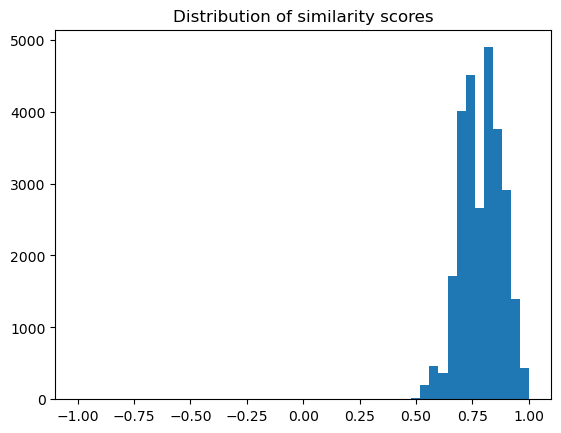

In [350]:
import matplotlib.pyplot as plt
plt.hist(similarity_scores, bins=50)
plt.title("Distribution of similarity scores")
plt.show()


In [351]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=32)
# item_embeddings = pca.fit_transform(X_item)

In [352]:
# item_embeddings

In [353]:
def recommend_similar_movies(movie_ids, embeddings_normalized, movies_data_clean, K=5):
    movie_indices = []
    for movie_id in movie_ids:
        movie_indices.append(
            item_features.index[item_features.movieId == movie_id][0]
        )
        
    profile = embeddings_normalized[movie_indices].mean(axis=0)
    print(profile)
    input()
    similarity_scores = embeddings_normalized.dot(profile)
    print(min(similarity_scores), max(similarity_scores))
    
    for ind in movie_indices:
        similarity_scores[ind] = -1.0
    
    top_k = np.argsort(similarity_scores)[-K:][::-1]
    recommended_movie_ids = item_features.iloc[top_k]['movieId']
    recommended_similarity_scores = similarity_scores[top_k]
    
    recommended_df = pd.DataFrame({
        'movieId': recommended_movie_ids,
        'similarity_score': np.round(recommended_similarity_scores, 4)
    })
    
    return recommended_df.join(
        movies_data_clean.set_index('movieId'), 
        on='movieId', 
        how='left'
    )[['movieId', 'title', 'genres','similarity_score']]

In [354]:
movie_indices = []
for movie_id in movie_ids[:5]:
    movie_indices.append(
        item_features.index[item_features.movieId == movie_id][0]
    )

AttributeError: 'DataFrame' object has no attribute 'movieId'

In [211]:
movie_indices

[np.int64(1), np.int64(5)]

In [212]:
recommend_similar_movies(list(movie_ids[:6]), embeddings_normalized, movies_data_clean, K=5)

[-1.00000000e+00  1.65786782e-06  3.54110650e-07 -5.65779566e-08
  9.83228354e-07 -8.58724327e-07 -8.27015735e-07 -9.98516002e-07
  3.39098614e-07  1.72620378e-06 -1.39238459e-07 -2.65231180e-07
 -4.91611264e-08 -5.87473673e-08 -1.26986150e-07 -3.48753427e-08
 -2.15475750e-08 -1.17989643e-08  7.87585434e-09 -3.48835726e-09
 -1.38520223e-08  4.79883083e-09 -1.57769479e-09  5.89338788e-10
  3.32602035e-10 -3.98409860e-09 -4.93718832e-09 -2.35200043e-09
  3.69000577e-09  2.61665429e-09  3.79100406e-10  1.45896167e-09]
-0.999999999990889 0.9999999999917526


,movieId,title,genres,similarity_score
7066,315840,Catacomb Kids,Action|Indie|RPG|Early Access,1.0
13713,311800,Black Ice,Action|Indie|RPG|Early Access,1.0
5848,347600,Total Miner,Action|Adventure|Indie|RPG|Early Access,1.0
20245,361330,Shrooms,Action|Adventure|Indie|RPG|Early Access,1.0
7535,332500,GRAV,Action|Adventure|Indie|RPG|Early Access,1.0


In [207]:
movieIds = list(item_features[1:2].movieId)

In [208]:
movie_names = movies_data_clean[movies_data_clean['movieId'].isin(movieIds)]['title']
# print(movie_names.tolist())
movie_genres = movies_data_clean[movies_data_clean['movieId'].isin(movieIds)]['genres']
# print(list(zip(movie_names.tolist(), movie_genres.tolist())))
for movie_name, movie_genres in zip(movie_names.tolist(), movie_genres.tolist()):
    print(movie_name, ':\t\t', movie_genres)

Mirror :		 Adventure|Indie|RPG
